In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from oracle_w_fuzzy import load_data
import pandas as pd

In [3]:
data = load_data()

In [4]:
def get_meta_data(data):
    res = {}
    for k, v in data['unlabeled_data'].max().to_dict().items():
        res[k] = {'max': v}
    for k, v in data['unlabeled_data'].min().to_dict().items():
        res[k].update({'min': v})    
    return res

In [5]:
get_meta_data(data)

{'sepal_length': {'max': 7.9, 'min': 4.4},
 'sepal_width': {'max': 4.4, 'min': 2.2}}

<AxesSubplot:>

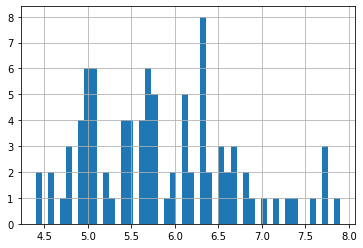

In [6]:
data['labeled_data']['x_train'].sepal_length.hist(bins=50)

<AxesSubplot:>

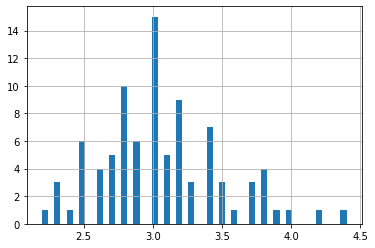

In [7]:
data['labeled_data']['x_train'].sepal_width.hist(bins=50)

<AxesSubplot:>

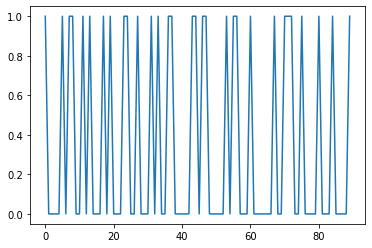

In [8]:
data['labeled_data']['y_train'].plot()

In [9]:
from h1st.model.predictive_model import PredictiveModel

class RuleModel(PredictiveModel):
    sepal_length_max: float = 6.0
    sepal_length_min: float = 4.0
    sepal_width_min: float = 2.8
    sepal_width_max: float = 4.6
    
    def predict(self, data):
        df = data['x']
        return {'predictions': pd.DataFrame(
            map(self.predict_setosa, df['sepal_length'], df['sepal_width']), 
            columns=['setosa'])}

    def predict_setosa(self, sepal_length, sepal_width):
        return 1 if (self.sepal_length_min <= sepal_length <= self.sepal_length_max) \
                  & (self.sepal_width_min <= sepal_width <= self.sepal_width_max) \
               else 0

In [10]:
import numpy as np
from h1st.model.fuzzy import (
    FuzzyVariables,
    FuzzyMembership as fm,
    FuzzyRules,
    FuzzyModeler
)


meta_data = get_meta_data(data)
fuzzy_vars = FuzzyVariables()
fuzzy_vars.add(
    var_name='sepal_length',
    var_type='antecedent',
    var_range=np.arange(
        meta_data['sepal_length']['min'], 
        meta_data['sepal_length']['max'], 
        0.1
    ),
    membership_funcs=[('small', fm.GAUSSIAN, [5, 0.7]),
                        ('large', fm.TRAPEZOID, [5.8, 6.4, 8, 8])]
)
fuzzy_vars.add(
    var_name='sepal_width',
    var_type='antecedent',
    var_range=np.arange(
        meta_data['sepal_width']['min'], 
        meta_data['sepal_width']['max'], 
        0.1
    ),
    membership_funcs=[('small', fm.GAUSSIAN, [2.8, 0.15]),
                        ('large', fm.GAUSSIAN, [3.3, 0.25])]
)
fuzzy_vars.add(
    var_name='setosa',
    var_type='consequent',
    var_range=np.arange(0, 1+1e-5, 0.1),
    membership_funcs=[('false', fm.GAUSSIAN, [0, 0.4]),
                      ('true', fm.GAUSSIAN, [1, 0.4])]
)
fuzzy_vars.add(
    var_name='non_setosa',
    var_type='consequent',
    var_range=np.arange(0, 1+1e-5, 0.1),
    membership_funcs=[('false', fm.GAUSSIAN, [0, 0.4]),
                      ('true', fm.GAUSSIAN, [1, 0.4])]
)

fuzzy_rule = FuzzyRules()
fuzzy_rule.add(
    'rule1',
    if_term=fuzzy_vars.get('sepal_length')['small'] & fuzzy_vars.get('sepal_width')['large'],
    then_term=fuzzy_vars.get('setosa')['true']
)
fuzzy_rule.add(
    'rule2',
    if_term=fuzzy_vars.get('sepal_length')['large'] & fuzzy_vars.get('sepal_width')['small'],
    then_term=fuzzy_vars.get('setosa')['false']
)
fuzzy_rule.add(
    'rule3',
    if_term=fuzzy_vars.get('sepal_length')['large'] & fuzzy_vars.get('sepal_width')['small'],
    then_term=fuzzy_vars.get('non_setosa')['true']
)
fuzzy_rule.add(
    'rule4',
    if_term=fuzzy_vars.get('sepal_length')['small'] & fuzzy_vars.get('sepal_width')['large'],
    then_term=fuzzy_vars.get('non_setosa')['false']
)

modeler = FuzzyModeler()
teacher = modeler.build_model(fuzzy_vars, fuzzy_rule)

=== Antecedents & Consequents ===


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


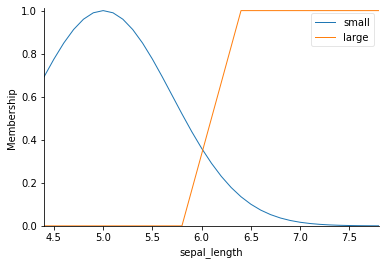

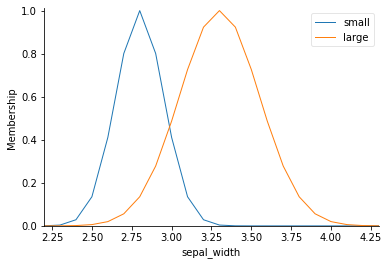

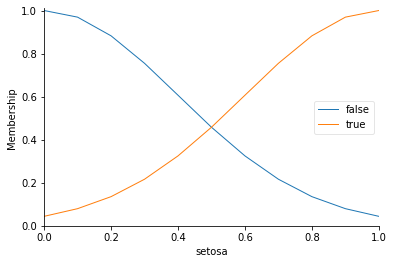

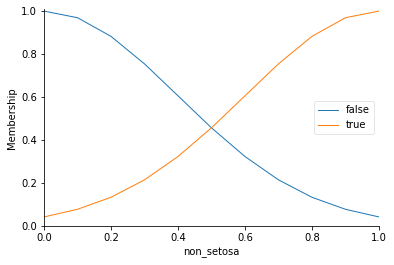

In [11]:
fuzzy_vars.visualize()

In [12]:
teacher_pred = teacher.predict({'x': data['labeled_data']['x_train']})['predictions']

In [13]:
data['unlabeled_data'].head()

,sepal_length,sepal_width
0,5.0,3.5
1,6.7,3.1
2,7.3,2.9
3,5.5,2.6
4,5.2,2.7


In [14]:
pd.concat([data['unlabeled_data'], data['unlabeled_data']['sepal_length']], axis=1)

,sepal_length,sepal_width,sepal_length
0,5.0,3.5,5.0
1,6.7,3.1,6.7
2,7.3,2.9,7.3
3,5.5,2.6,5.5
4,5.2,2.7,5.2
...,...,...,...
85,5.8,2.7,5.8
86,5.8,2.6,5.8
87,6.3,2.9,6.3
88,5.8,2.7,5.8


In [15]:
teacher.predict({"x": {"sepal_length": 5.0, "sepal_width": 3.5}})

{'predictions':     setosa  non_setosa
 0  0.66542     0.33458}

In [16]:
# Using plotly.express
import plotly.express as px

fig = px.line(teacher_pred)
fig.show()

In [17]:
teacher_pred.head()

,setosa,non_setosa
0,0.66542,0.33458
1,0.46683,0.53317
2,0.32569,0.67431
3,0.50000,0.50000
4,0.50182,0.49818


In [18]:
from sklearn import metrics
output = list(map(lambda x: 1 if x > 0.6 else 0, teacher_pred['setosa']))
# temp = teacher.predict(data['training_data'])['predictions']
metrics.accuracy_score(output, data['labeled_data']['y_train'])

0.8777777777777778

In [19]:
from sklearn import metrics
output = list(map(lambda x: 1 if x > 0.49 else 0, teacher_pred['non_setosa']))
# temp = teacher.predict(data['training_data'])['predictions']
y_true = data['labeled_data']['y_train'].apply(lambda x: x ^ 1).rename('non_setosa')
metrics.accuracy_score(output, y_true)

0.8111111111111111

In [20]:
rule_model = RuleModel()

In [21]:
temp = rule_model.predict({'x': data['labeled_data']['x_train']})['predictions']
metrics.accuracy_score(temp, data['labeled_data']['y_train'])

0.9

In [22]:
data['labeled_data']['y_train'] = pd.concat(
    [data['labeled_data']['y_train'].rename('setosa'), 
    data['labeled_data']['y_train'].apply(lambda x: x ^ 1).rename('non_setosa')], 
    axis=1
)

In [23]:
data['labeled_data']['y_test'] = pd.concat(
    [data['labeled_data']['y_test'].rename('setosa'), 
    data['labeled_data']['y_test'].apply(lambda x: x ^ 1).rename('non_setosa')], 
    axis=1
)

In [24]:
from h1st.model.oracle import OracleModeler

In [25]:
modeler = OracleModeler()

In [26]:
fuzzy_thresholds = {'setosa': 0.6, 'non_setosa': 0.49}

oracle = modeler.build_model(
    data=data, 
    teacher=teacher,
    fuzzy_thresholds=fuzzy_thresholds)

AttributeError: 'numpy.ndarray' object has no attribute 'mode'

In [ ]:
test_data = {'x': data['labeled_data']['x_test']}
prediction = oracle.predict(test_data)

In [ ]:
oracle.metrics

{}

In [ ]:
oracle2 = modeler.build_model(
    data=data, 
    teacher=rule_model)

test_data = {'x': data['labeled_data']['x_test']}
prediction = oracle2.predict(test_data)

ERROR:root:Couldn't complete the submodel evaluation.


In [ ]:
oracle2.metrics

{}

In [ ]:
from h1st.model.oracle.ensemble import GradBoostEnsembleModeler

In [ ]:
oracle3 = modeler.build_model(
    data=data, 
    teacher=rule_model,
    ensembler_modeler=GradBoostEnsembleModeler())

test_data = {'x': data['labeled_data']['x_test']}
prediction = oracle3.predict(test_data)

INFO:root:Evaluated all sub models successfully.


In [ ]:
oracle3.ensemblers

{'setosa': <h1st.model.oracle.ensemble.GradBoostEnsemble at 0x7fecc2b5de50>}

In [ ]:
oracle3.metrics

{'accuracy': {'setosa': {'teacher': 0.86667,
   'students': [0.86667, 0.93333],
   'ensemblers': 0.95}},
 'f1_score': {'setosa': {'teacher': 0.81818,
   'students': [0.81818, 0.90476],
   'ensemblers': 0.91892}}}

In [ ]:
fuzzy_thresholds = {'setosa': 0.6, 'non_setosa': 0.49}
oracle4 = modeler.build_model(
    data=data, 
    teacher=teacher,
    fuzzy_thresholds=fuzzy_thresholds,
    ensembler_modeler=GradBoostEnsembleModeler())

test_data = {'x': data['labeled_data']['x_test']}
prediction = oracle4.predict(test_data)

INFO:root:Evaluated all sub models successfully.


In [ ]:
oracle4.metrics

{'accuracy': {'setosa': {'teacher': 0.83333,
   'students': [0.9, 0.93333],
   'ensemblers': 0.95},
  'non_setosa': {'teacher': 0.81667,
   'students': [0.83333, 0.95],
   'ensemblers': 0.95}},
 'f1_score': {'setosa': {'teacher': 0.73684,
   'students': [0.83333, 0.88889],
   'ensemblers': 0.91892},
  'non_setosa': {'teacher': 0.85714,
   'students': [0.86842, 0.96203],
   'ensemblers': 0.96386}}}

In [ ]:
prediction

{'predictions': {'setosa': array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]),
  'non_setosa': array([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
         1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0])}}

In [ ]:
assert 1 == 0

AssertionError: 

In [ ]:
import os
path = '/Users/aitomatic/src/github/h1st-ai/h1st/user/example-models/oracle'
os.environ['H1ST_MODEL_REPO_PATH'] = path

In [ ]:
oracle4.persist('test_ml_ensemble_oracle')

In [ ]:
oracle4 = None

In [ ]:
from h1st.model.oracle import Oracle
oracle4 = Oracle()
oracle4.load('test_ml_ensemble_oracle')

In [ ]:
oracle4.stats['model_details']

In [ ]:
oracle4.students

In [ ]:
test_data = {'x': data['test_data']['x']}
prediction_from_loaded = oracle4.predict(test_data)

In [ ]:
prediction_from_loaded
# something is wrong. setosa is same as non_setosa.

In [ ]:
prediction

In [ ]:
class MyClass:

    def __init__(self):
        self._vars = {}

    @property
    def vars(self):
        # Do something if you want
        return self._vars

    @vars.setter
    def vars(self, dict_):
        # Do something if you want
        self._vars.update(dict_)

    def add_vars(self, k, v):
        self._vars.update({k: v})

In [ ]:
my = MyClass()

In [ ]:
my.add_vars('a', 1)

In [ ]:
my.vars['a']

In [ ]:
my.vars = {'a': 1}
my.vars = {'b': 7}

In [ ]:
my.vars